## Compare different Under Sampling using Different Datasets - II

- In this notebook, we will try to compare different under sampling methods on different datasets using a Random Forest Model with Cross Validation
- The main take here is that whenever we perform under sampling technique to balance our dataset, we should train our model on the under sampled trained set BUT we should use the original test set for evaluation ( meaning the test set should not be under sampled)
- When we train a classifier, we want it to predict an outcome in a real life dataset. The real datasets, most likely, also have a class imbalance. Thus, it is important to evaluate the performance of the classifier, on a data set with the same distribution of classes, as the one we expect in real life.

This means, that the under-sampling methods should be performed on the dataset that we are going to use to train the classifier. But, **the performance of the model should be determined on a portion of the data, that was not re-sampled**.

In this notebook, we will use the imbalanced-learn pipeline, to set up various under-sampling solutions, in a way that we train the model on re-sampled data, but we evaluate performance on non resampled data.

In [102]:
# import libraries
import numpy as np
import pandas as pd

# for counting
from collections import Counter

# for plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler

# from imblearn
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    TomekLinks,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    OneSidedSelection,
    InstanceHardnessThreshold
)

## Initialize under sampling methods

- Lets create a dictionary that contains the initialization of all our Under Sampling methods

In [101]:
undersampler_dict = {
    
    'random' : RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=True),
    
    'cnn' : CondensedNearestNeighbour(
        sampling_strategy='auto',
        n_neighbors=1,
        random_state=0,n_jobs=2),
    
    'enn' : EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=2),
  
    'renn' : RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=2,
        max_iter=100),
  
    'tomek' : TomekLinks(
        sampling_strategy='auto',
        n_jobs=2),
    
    'allknn' : AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=2),
    
    'ncr' : NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=2,
        threshold_cleaning=0.5),
    
    'oss' : OneSidedSelection(
                            sampling_strategy='auto',
                            random_state=0,
                            n_neighbors=1,
                            n_jobs=2),
    
    
    'ncr' : NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=2,
        threshold_cleaning=0.5),
    
    'oss' : OneSidedSelection(
                            sampling_strategy='auto',
                            random_state=0,
                            n_neighbors=1,
                            n_jobs=2),
    
    'nm1' : NearMiss(sampling_strategy='auto',
                     version=1,
                     n_neighbors=3,
                     n_jobs=2),
    
    'nm2' : NearMiss(sampling_strategy='auto',
                     version=2,
                     n_neighbors=3,
                     n_jobs=2),
    

    'iht' : InstanceHardnessThreshold(
        estimator=RandomForestClassifier(n_estimators=100,max_depth=3, n_jobs=2,random_state=39), 
                                     sampling_strategy='auto',
                                     cv=3,
                                     random_state=0,
                                     n_jobs=2)  
}

In [103]:
# lets define the datasets to use - as a list of datasets names
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [104]:
# getting the datasets

data = fetch_datasets()['ecoli']
data

{'data': array([[0.49, 0.29, 0.48, ..., 0.56, 0.24, 0.35],
        [0.07, 0.4 , 0.48, ..., 0.54, 0.35, 0.44],
        [0.56, 0.4 , 0.48, ..., 0.49, 0.37, 0.46],
        ...,
        [0.61, 0.6 , 0.48, ..., 0.44, 0.39, 0.38],
        [0.59, 0.61, 0.48, ..., 0.42, 0.42, 0.37],
        [0.74, 0.74, 0.48, ..., 0.31, 0.53, 0.52]]),
 'target': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

In [106]:
data.data[0][:]

array([0.49, 0.29, 0.48, 0.5 , 0.56, 0.24, 0.35])

In [107]:
pd.Series(data.target).value_counts()

-1    301
 1     35
dtype: int64

In [108]:
# lets try to check the data imbalance for all the data in our dataset list

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    data = pd.Series(data.target)
    print(data.value_counts())

car_eval_34
-1    1594
 1     134
dtype: int64
ecoli
-1    301
 1     35
dtype: int64
thyroid_sick
-1    3541
 1     231
dtype: int64
arrhythmia
-1    427
 1     25
dtype: int64
ozone_level
-1    2463
 1      73
dtype: int64


In [39]:
# can do this way as well
for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [129]:
# lets create a function to train random forest model and evaluate the model with cross validation

def run_model(X_train, y_train, undersampler=None):
    
    # set up the classifier
    rf = RandomForestClassifier(n_estimators=100, n_jobs=2, max_depth=4, random_state=39)
    
    # set up a scaler 
    # (as many undersampling techniques use KNN
    # we put the variables in the same scale)
    scaler = MinMaxScaler()
        
    # without under sampling
    if not undersampler:
        model = rf
        
    # set up a pipeline with under-sampling
    else:
        # important to scale before the under-sampler
        # as the many of methods require the variables in 
        # a similar scale
        model = make_pipeline(
            scaler,
            undersampler,
            rf
        )
        
    
    # now fit the model using cross validation and evaluate the performance metrics
    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:
    
    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled
    
    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the under-sampled data
    
    cv_results = cross_validate(model,
                                X_train,
                                y_train,
                                cv=3,
                                scoring="average_precision",
                                n_jobs=2) 
    return cv_results

In [130]:
data = fetch_datasets()['ecoli']
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=1)
for sampler in undersampler_dict.keys():
    cv = run_model(X_train, y_train, undersampler_dict[sampler])
    break

In [131]:
# we are getting 3 values each as we are performing 3 fold cross validation
# each results for each fold
cv

{'fit_time': array([0.13800144, 0.13699841, 0.1269567 ]),
 'score_time': array([0.02399659, 0.02499962, 0.02596974]),
 'test_score': array([0.6601443 , 0.38449085, 0.70502229])}

In [132]:
print(cv['test_score'].mean())
print(cv['test_score'].std())

0.5832191480017567
0.1417114685336051


In [136]:
# rewriting the same function again for displaying and printing out all the results of each dataset and under sampler
# lets create a function to train random forest model and evaluate the model with cross validation

def run_model(X_train, y_train, undersampler=None):
    
    # set up the classifier
    rf = RandomForestClassifier(n_estimators=100, n_jobs=2, max_depth=4, random_state=39)
    
    # set up a scaler 
    # (as many undersampling techniques use KNN
    # we put the variables in the same scale)
    scaler = MinMaxScaler()
        
    # without under sampling
    if not undersampler:
        model = rf
        
    # set up a pipeline with under-sampling
    else:
        # important to scale before the under-sampler
        # as the many of methods require the variables in 
        # a similar scale
        model = make_pipeline(
            scaler,
            undersampler,
            rf
        )
        
    
    # now fit the model using cross validation and evaluate the performance metrics
    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:
    
    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled
    
    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the under-sampled data
    
    cv_results = cross_validate(model,
                                X_train,
                                y_train,
                                cv=3,
                                scoring="average_precision",
                                n_jobs=2) 
    
    # display the mean and std of the test scores given by the model
    print('Random Forest Average Precision: {0} +/- {1}'.format(cv_results['test_score'].mean(), 
                                                                cv_results['test_score'].std()))
    
    # returnt the mean score and std
    return cv_results['test_score'].mean(), cv_results['test_score'].std()

### calling the function for all datasets and for all under sampler methods

In [137]:
mean_dict = dict()
std_dict = dict()

for dataset in datasets_ls:
    print(dataset)
    
    mean_dict[dataset] = {}
    std_dict[dataset] = {}
    
    data = fetch_datasets()[dataset]
    
    # split into Train and Test data
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=0)
    # print(X_train.shape, X_test.shape)

    # run the RF model and get the ROC values for the original data set
    mean, std = run_model(X_train, y_train)
    
    mean_dict[dataset]['full_data'] = mean
    std_dict[dataset]['full_data'] = std
    
    print()
    
    # now test using different under sampling methods one at a time
    for sampler in undersampler_dict.keys():

        # display the under sampler name
        print(sampler)        
        
        # run the function for each under sampler for the resampled data sets
        mean, std = run_model(X_train, y_train, undersampler_dict[sampler])
        
        # store the results
        mean_dict[dataset][sampler] = mean
        std_dict[dataset][sampler] = std
        
        print()
    print()


car_eval_34
Random Forest Average Precision: 0.8207287954705275 +/- 0.048666919598426686

random
Random Forest Average Precision: 0.8673082162588837 +/- 0.039970502151167035

cnn
Random Forest Average Precision: 0.8479860713595687 +/- 0.027333727660020454

enn
Random Forest Average Precision: 0.8094719390151046 +/- 0.05358211852730241

renn
Random Forest Average Precision: 0.8402520516970408 +/- 0.05779525074730297

tomek
Random Forest Average Precision: 0.8334875111835851 +/- 0.055999465675532066

allknn
Random Forest Average Precision: 0.8015232318537479 +/- 0.07321803076497946

ncr
Random Forest Average Precision: 0.8194933814408993 +/- 0.043880400318127726

oss
Random Forest Average Precision: 0.8134049044128328 +/- 0.049646043419862264

nm1
Random Forest Average Precision: 0.8943485093554805 +/- 0.04303328926658031

nm2
Random Forest Average Precision: 0.5035888371711364 +/- 0.05246871810636031

iht
Random Forest Average Precision: 0.620758292251503 +/- 0.03593956490924306


ecoli

In [138]:
# lets print the results_dict()
print(mean_dict)

{'car_eval_34': {'full_data': 0.8207287954705275, 'random': 0.8673082162588837, 'cnn': 0.8479860713595687, 'enn': 0.8094719390151046, 'renn': 0.8402520516970408, 'tomek': 0.8334875111835851, 'allknn': 0.8015232318537479, 'ncr': 0.8194933814408993, 'oss': 0.8134049044128328, 'nm1': 0.8943485093554805, 'nm2': 0.5035888371711364, 'iht': 0.620758292251503}, 'ecoli': {'full_data': 0.6819187371270704, 'random': 0.5765479675844308, 'cnn': 0.6108002756100582, 'enn': 0.6610729941403422, 'renn': 0.6200148658303394, 'tomek': 0.688223553693755, 'allknn': 0.6473520666576222, 'ncr': 0.6535642842240065, 'oss': 0.6689947736580303, 'nm1': 0.18752944753317677, 'nm2': 0.268446641008622, 'iht': 0.30732100738905294}, 'thyroid_sick': {'full_data': 0.791097012129098, 'random': 0.7933159147812163, 'cnn': 0.8458732088905455, 'enn': 0.7354791296900087, 'renn': 0.7295313376229249, 'tomek': 0.7952658664176688, 'allknn': 0.7434979147642403, 'ncr': 0.7821069189216766, 'oss': 0.7920573430086021, 'nm1': 0.24957029845

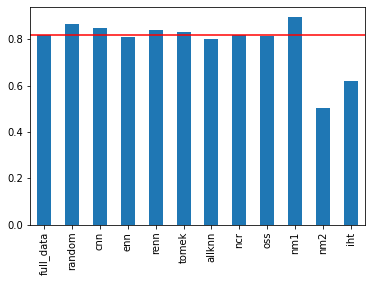

In [153]:
test = mean_dict['car_eval_34']
pd.Series(test).plot.bar()
plt.axhline(mean_dict['car_eval_34']['full_data'], c = 'red')
plt.show()

full_data    0.048667
random       0.039971
cnn          0.027334
enn          0.053582
renn         0.057795
tomek        0.055999
allknn       0.073218
ncr          0.043880
oss          0.049646
nm1          0.043033
nm2          0.052469
iht          0.035940
dtype: float64


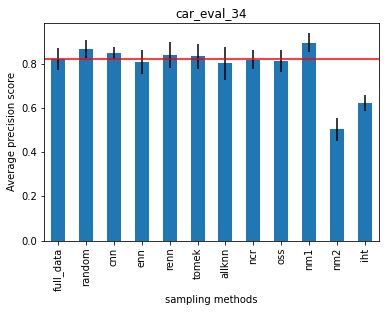

full_data    0.103148
random       0.068617
cnn          0.081757
enn          0.106417
renn         0.073972
tomek        0.114514
allknn       0.072231
ncr          0.111801
oss          0.131737
nm1          0.065518
nm2          0.047750
iht          0.106123
dtype: float64


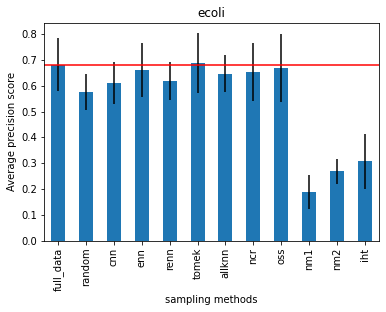

full_data    0.049506
random       0.073869
cnn          0.040180
enn          0.040272
renn         0.054369
tomek        0.038440
allknn       0.045904
ncr          0.052791
oss          0.035250
nm1          0.061406
nm2          0.153715
iht          0.025671
dtype: float64


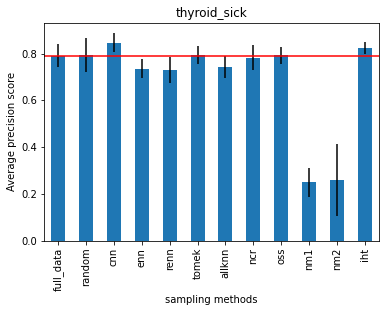

full_data    0.110728
random       0.100335
cnn          0.056776
enn          0.103069
renn         0.043235
tomek        0.093892
allknn       0.051578
ncr          0.178277
oss          0.070640
nm1          0.036007
nm2          0.085163
iht          0.072184
dtype: float64


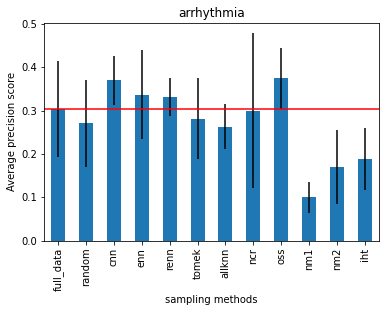

full_data    0.083537
random       0.116732
cnn          0.042538
enn          0.063423
renn         0.044325
tomek        0.058666
allknn       0.041355
ncr          0.081095
oss          0.079691
nm1          0.025059
nm2          0.072379
iht          0.009562
dtype: float64


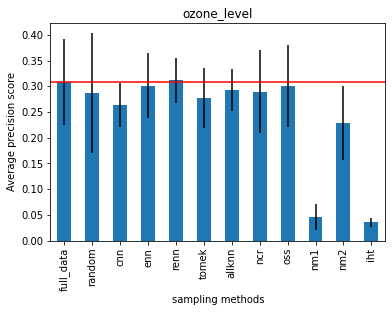

In [155]:
# plotting for all the sampling methods agains the full data 

for dataset in datasets_ls:
    
    mean_vals = pd.Series(mean_dict[dataset])
    std_vals = pd.Series(std_dict[dataset])
    print(std_vals)
    mean_vals.plot.bar(yerr=[std_vals,std_vals])
    
    plt.title('{}'.format(dataset))
    plt.ylabel('Average precision score')
    plt.xlabel('sampling methods')
    
    plt.axhline(mean_dict[dataset]['full_data'],c='red')
    plt.show()

- WE can conclude that different sampling methods works differently for different datasets
- **Different under-sampling techniques work best for different datasets.**
- ENN, RENN and AllKNN tend to produce similar results, so we may as well just choose one of the 3